# Emergency Vehicle Detector

## Project done by : Jaitashri Poddar

# Project Description

Fatalities due to traffic delays of emergency vehicles such as ambulance & fire brigade is a huge problem. In daily life, we often see that emergency vehicles face difficulty in passing through traffic. So differentiating a vehicle into an emergency and non emergency category can be an important component in traffic monitoring as well as self drive car systems as reaching on time to their destination is critical for these services. <br> <br>
In this project, the created deep learning based model classifies vehicle images as either emergency or non-emergency. Emergency vehicles typically include police cars, ambulances, and fire brigades. 

# Data Description

The training and testing datasets have been taken from [Kaggle](https://www.kaggle.com/datasets/abhisheksinghblr/emergency-vehicles-identification). <br>
**train.zip:** contains 2 csvs and 1 folder containing image data <br>
**train.csv** – [‘image_names’, ‘emergency_or_not’] contains the image name and correct class for 1646 (70%) train images <br>
**images** – contains 2352 images for both train and test sets <br>
**test.csv:** [‘image_names’] contains just the image names for the 706 (30%) test images

# 1. Importing Libraries and Setting Options

## 1.1 Importing Necessary LIbraries

In [1]:
# suppress display of warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the NumPy library for numerical operations
import numpy as np

# Importing the Pandas library for data manipulation and analysis
import pandas as pd

# Importing the Matplotlib library for plotting and visualization
import matplotlib.pyplot as plt

# Importing the train_test_split function from scikit-learn for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# Importing the shuffle function from scikit-learn for shuffling the dataset
from sklearn.utils import shuffle

# Importing the ImageDataGenerator class from TensorFlow Keras for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing the Sequential class from TensorFlow Keras to initialize a sequential model
from tensorflow.keras.models import Sequential

# Importing various layers from TensorFlow Keras for building the neural network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Importing the EarlyStopping callback from TensorFlow Keras to stop training when a monitored metric has stopped improving
from tensorflow.keras.callbacks import EarlyStopping



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-07-11 23:55:48.246105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.2 Setting Figure Size

In [2]:
# set the plot size using 'rcParams'
# once the plot size is set using 'rcParams', it sets the size of all the forthcoming plots in the file
# pass width and height in inches to 'figure.figsize' 
plt.rcParams['figure.figsize'] = [15,8]

## 1.3 Setting Options

In [3]:
# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# use below code to convert the 'exponential' values to float
np.set_printoptions(suppress=True)

# 2. Loading Data

In [4]:
#Let's name the dataset as train_data
train_data = pd.read_csv('train.csv')

In [5]:
train_data.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB


# 3. Data Preprocessing and Analysis

In [7]:
#Let's convert the target column to string
train_data['emergency_or_not'] = train_data['emergency_or_not'].astype('string') 

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   string
dtypes: object(1), string(1)
memory usage: 25.8+ KB


In [9]:
train_data['emergency_or_not'].value_counts()

emergency_or_not
0    965
1    681
Name: count, dtype: Int64

In [10]:
# Data preprocessing

# Images are stored in a folder named 'train'
# Create a list of image paths by concatenating the folder name with image file names from the 'train_data' DataFrame
image_paths = ['train/' + img_name for img_name in train_data['image_names']]

# Extract the labels for each image from the 'train_data' DataFrame
labels = train_data['emergency_or_not']

In [11]:
# Split the data into training and validation sets

# Use train_test_split to split the image paths and labels into training and validation sets
# test_size=0.2 means 20% of the data will be used for validation
# random_state=42 ensures reproducibility of the split
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

## Data Augmentation

In [12]:
# Initialize ImageDataGenerator for training data with rescaling
# rescale=1./255 scales the pixel values to the range [0, 1]
# We should not perform data augmentation on the test or validation data
train_datagen = ImageDataGenerator(rescale=1./255)

# Initialize ImageDataGenerator for validation data with rescaling
# Again, we should not perform data augmentation on the validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for the training set
# flow_from_dataframe generates batches of tensor image data with real-time data augmentation
# dataframe contains image paths and corresponding labels
# x_col specifies the column in the dataframe that contains the image paths
# y_col specifies the column that contains the labels
# target_size resizes all images to 224x224 pixels
# batch_size specifies the number of images to be yielded from the generator per batch
# class_mode='binary' because we have binary classification (emergency or non-emergency)
train_generator = train_datagen.flow_from_dataframe(dataframe=pd.DataFrame({'image_paths': X_train, 'labels': y_train}),
                                                    x_col='image_paths', y_col='labels',
                                                    target_size=(224, 224), batch_size=32, class_mode='binary')

# Create a data generator for the validation set using the same parameters as for the training set
val_generator = val_datagen.flow_from_dataframe(dataframe=pd.DataFrame({'image_paths': X_val, 'labels': y_val}),
                                                x_col='image_paths', y_col='labels',
                                                target_size=(224, 224), batch_size=32, class_mode='binary')


Found 1316 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


# 4. Model Building

## 4.1 Using Custom Model

In [14]:
# Define the model architecture

# Initialize a Sequential model
custom_model = Sequential([
    # Add a 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and input shape 224x224x3 (for RGB images)
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    
    # Add a 2D max pooling layer with a 2x2 pool size to reduce the spatial dimensions
    MaxPooling2D((2, 2)),
    
    # Add another 2D convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
    Conv2D(64, (3, 3), activation='relu'),
    
    # Add another 2D max pooling layer with a 2x2 pool size
    MaxPooling2D((2, 2)),
    
    # Add another 2D convolutional layer with 128 filters, a 3x3 kernel, and ReLU activation
    Conv2D(128, (3, 3), activation='relu'),
    
    # Add another 2D max pooling layer with a 2x2 pool size
    MaxPooling2D((2, 2)),
    
    # Flatten the 3D output to 1D for the fully connected layers
    Flatten(),
    
    # Add a fully connected (dense) layer with 128 units and ReLU activation
    Dense(128, activation='relu'),
    
    # Add a dropout layer with a 50% dropout rate to prevent overfitting
    Dropout(0.5),
    
    # Add the output layer with 1 unit and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

2024-07-12 00:22:00.737471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Compile the model

# Compile the model with the following parameters:
# optimizer='adam': Use the Adam optimizer for training
# loss='binary_crossentropy': Use binary cross-entropy as the loss function since this is a binary classification problem
# metrics=['accuracy']: Evaluate the model using accuracy as the metric
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model

# Set up early stopping to monitor the validation loss and stop training if it doesn't improve for 5 consecutive epochs
# restore_best_weights=True ensures that the model will restore the weights from the epoch with the best validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the fit method
# train_generator: The training data generator
# steps_per_epoch: The number of steps (batches of samples) to yield from the generator before declaring one epoch finished
# epochs: The number of epochs to train the model
# validation_data: The validation data generator
# validation_steps: The number of steps (batches of samples) to yield from the validation generator
# callbacks: A list of callback instances to apply during training (here we use early stopping)
history = custom_model.fit(train_generator, steps_per_epoch=len(X_train)//32, epochs=50,
                           validation_data=val_generator, validation_steps=len(X_val)//32,
                           callbacks=[early_stopping])

Epoch 1/50
41/41 [==============================] - 38s 898ms/step - loss: 0.6861 - accuracy: 0.6682 - val_loss: 0.6100 - val_accuracy: 0.6875
Epoch 2/50
41/41 [==============================] - 41s 992ms/step - loss: 0.4812 - accuracy: 0.7796 - val_loss: 0.4957 - val_accuracy: 0.7656
Epoch 3/50
41/41 [==============================] - 43s 1s/step - loss: 0.3977 - accuracy: 0.8263 - val_loss: 0.4341 - val_accuracy: 0.8031
Epoch 4/50
41/41 [==============================] - 48s 1s/step - loss: 0.3087 - accuracy: 0.8699 - val_loss: 0.3723 - val_accuracy: 0.8281
Epoch 5/50
41/41 [==============================] - 48s 1s/step - loss: 0.2317 - accuracy: 0.9081 - val_loss: 0.4254 - val_accuracy: 0.7969
Epoch 6/50
36/41 [=========================>....] - ETA: 5s - loss: 0.1417 - accuracy: 0.9457

In [24]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = custom_model.fit(train_generator, steps_per_epoch=len(X_train)//32, epochs=50,
                    validation_data=val_generator, validation_steps=len(X_val)//32,
                    callbacks=[early_stopping])

Epoch 1/50
41/41 [==============================] - 36s 835ms/step - loss: 0.7574 - accuracy: 0.6199 - val_loss: 0.5506 - val_accuracy: 0.7125
Epoch 2/50
41/41 [==============================] - 41s 990ms/step - loss: 0.5358 - accuracy: 0.7516 - val_loss: 0.5563 - val_accuracy: 0.7312
Epoch 3/50
41/41 [==============================] - 41s 1s/step - loss: 0.4939 - accuracy: 0.7718 - val_loss: 0.4707 - val_accuracy: 0.7844
Epoch 4/50
41/41 [==============================] - 43s 1s/step - loss: 0.4182 - accuracy: 0.8185 - val_loss: 0.4731 - val_accuracy: 0.7781
Epoch 5/50
41/41 [==============================] - 43s 1s/step - loss: 0.3617 - accuracy: 0.8388 - val_loss: 0.4331 - val_accuracy: 0.8156
Epoch 6/50
41/41 [==============================] - 44s 1s/step - loss: 0.3015 - accuracy: 0.8715 - val_loss: 0.3969 - val_accuracy: 0.8188
Epoch 7/50
41/41 [==============================] - 45s 1s/step - loss: 0.2440 - accuracy: 0.9034 - val_loss: 0.5117 - val_accuracy: 0.7875
Epoch 8/50
41/

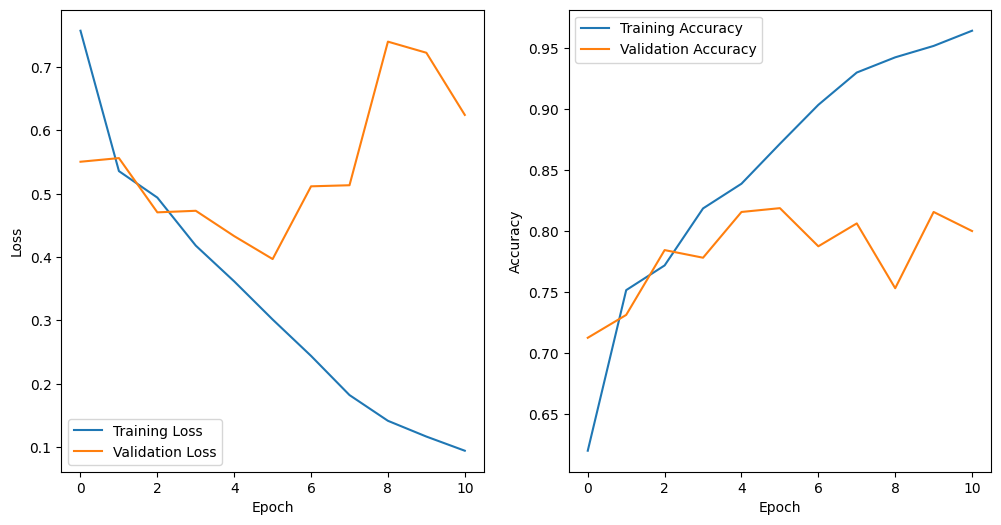

In [25]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Evaluate the model on validation data
loss, accuracy = custom_model.evaluate(val_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


11/11 [==============================] - 4s 349ms/step - loss: 0.4012 - accuracy: 0.8152
Validation Loss: 0.4011639356613159
Validation Accuracy: 0.8151515126228333


## VGG16 Model

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [10]:
from tensorflow.keras.optimizers.legacy import Adam

In [11]:
# Load VGG16 model pre-trained on ImageNet without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-05-17 01:31:02.017108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58889256/58889256 [==============================] - 6s 0us/step


In [12]:
# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Create the model architecture by adding custom top layers
vgg16_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [14]:
# Compile the model
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = vgg16_model.fit(train_generator, steps_per_epoch=len(X_train)//32, epochs=50,
                    validation_data=val_generator, validation_steps=len(X_val)//32,
                    callbacks=[early_stopping])

Epoch 1/50
41/41 [==============================] - 373s 9s/step - loss: 0.9685 - accuracy: 0.7710 - val_loss: 0.2957 - val_accuracy: 0.8781
Epoch 2/50
41/41 [==============================] - 7581s 189s/step - loss: 0.2472 - accuracy: 0.9058 - val_loss: 0.2278 - val_accuracy: 0.9031
Epoch 3/50
41/41 [==============================] - 38687s 943s/step - loss: 0.2010 - accuracy: 0.9252 - val_loss: 0.1985 - val_accuracy: 0.9219
Epoch 4/50
41/41 [==============================] - 25364s 610s/step - loss: 0.1351 - accuracy: 0.9447 - val_loss: 0.2102 - val_accuracy: 0.9219
Epoch 5/50
41/41 [==============================] - 9527s 238s/step - loss: 0.0872 - accuracy: 0.9766 - val_loss: 0.1896 - val_accuracy: 0.9281
Epoch 6/50
41/41 [==============================] - 436s 11s/step - loss: 0.0666 - accuracy: 0.9798 - val_loss: 0.2236 - val_accuracy: 0.9062
Epoch 7/50
41/41 [==============================] - 455s 11s/step - loss: 0.0714 - accuracy: 0.9743 - val_loss: 0.2173 - val_accuracy: 0.92

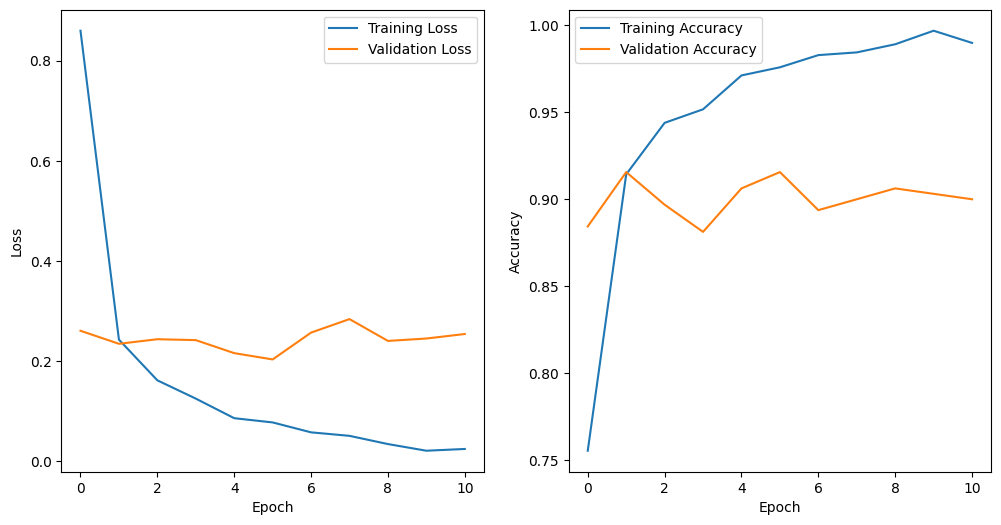

In [34]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
# Evaluate the model on validation data
loss, accuracy = vgg16_model.evaluate(val_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


11/11 [==============================] - 79s 7s/step - loss: 0.1980 - accuracy: 0.9182
Validation Loss: 0.19800449907779694
Validation Accuracy: 0.918181836605072


In [36]:
import tensorflow as tf

In [37]:
tf.__version__

'2.15.0'

In [38]:
#Saving VGG16 model as h5 file

#from tensorflow.keras.models import load_model
#vgg16_model.save('model_vgg16.h5')
import pickle
vgg16_model.save('model_vgg16_pkl.pkl')

C:\Users\JPoddar\AppData\Local\anaconda3\envs\DL10\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
!pip install flask

   ---------------------------------------- 0.0/101.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/101.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/101.7 kB ? eta -:--:--
   --------------- ----------------------- 41.0/101.7 kB 330.3 kB/s eta 0:00:01
   ----------------------------------- --- 92.2/101.7 kB 525.1 kB/s eta 0:00:01
   -------------------------------------- 101.7/101.7 kB 489.3 kB/s eta 0:00:00


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
!pip install Werkzeug

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.2 MB/s eta 0:00:00a 0:00:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2


In [4]:
import tensorflow as tf

2024-05-21 01:46:32.741557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
tf.__version__

'2.11.0'

In [7]:
import numpy as np

In [8]:
np.__version__

'1.24.3'